# Structure Representation Computation from Audio Input
### Comparing difference between no filtering vs all filtering

## > Library importing

In [3]:
#Computation
import numpy as np
import scipy
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt
import cv2

#Data Processing
import sklearn.cluster

#Audio
import librosa
from librosa import display

#System
import glob
import os
import sys

#Pickling
import dill

## > Loading audio

In [4]:
#Choose directory containing audiofiles
directory = '../../test_dataset'

#Read all paths in specified directory
all_filepaths = []
all_names= []
for root, dirs, files in os.walk(directory):
        for name in files:
            if (('.wav' in name) or ('.aif' in name) or ('.mp3' in name)):
                filepath = os.path.join(root, name)
                all_filepaths.append(filepath)
                all_names.append(name[:-4])

#Dictionary containing all batches of matrices as described by pipeline documentation in a linearized, sequential format
X = {}

#Load all audiofiles and store in array
all_audio = []
file_no = len(all_filepaths)
for f in range(file_no):
    y, sr = librosa.load(all_filepaths[f], sr=22050, mono=True)
    all_audio.append((y, sr))
    sys.stdout.write("\rLoaded %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()
    
X["audio"] = all_audio

Loaded 8/8 pieces.

## > Self Similarity for Repetitions

### >> Single-Feature Self Similarity Matrix

In [7]:
X["spectral_rep"]={"logCQT":[]}

for f in range(file_no):

    #Log-power Constant-Q Transform
    bins_per_oct = 12*3
    n_oct = 7
    CQT = librosa.cqt(y=X["audio"][f][0], sr=X["audio"][f][1], bins_per_octave=bins_per_oct, n_bins=n_oct*bins_per_oct)

    X["spectral_rep"]["logCQT"].append(librosa.amplitude_to_db(CQT))

    sys.stdout.write("\rComputed CQT for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()
    


Computed CQT for 8/8 pieces.

### >> Beat Synchronization

In [9]:
X["reduced_spectral_rep"] = {"logCQT_beat":[]}

for f in range(file_no):

    #Beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=X["audio"][f][0], sr=X["audio"][f][1], trim=False)
    X["reduced_spectral_rep"]["logCQT_beat"].append(librosa.util.sync(X["spectral_rep"]["logCQT"][f], beats, aggregate=np.median))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Short-term History Embedding of spectral representation

In [12]:
steps = 4
X["stacked_spectral_rep"] = {"stacked_logCQT":[]}
for f in range(file_no):
    X["stacked_spectral_rep"]["stacked_logCQT"].append(librosa.feature.stack_memory(X["reduced_spectral_rep"]["logCQT_beat"][f], steps))
    
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Weighted Recurrence Matrix

In [14]:
knn_no = 3
X["ssm"] = {"logCQT":[], "f_logCQT":[]}
for f in range(file_no):
    X["ssm"]["logCQT"].append(librosa.segment.recurrence_matrix(X["reduced_spectral_rep"]["logCQT_beat"][f], width=knn_no, mode='affinity', sym=True))
    X["ssm"]["f_logCQT"].append(librosa.segment.recurrence_matrix(X["stacked_spectral_rep"]["stacked_logCQT"][f], width=knn_no, mode='affinity', sym=True))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Timelag filter & Path enhancement

In [16]:
X["f_ssm"] = {"f_logCQT":[]}
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)

for f in range(file_no):
    X["f_ssm"]["f_logCQT"].append(librosa.segment.path_enhance(df(X["ssm"]["f_logCQT"][f], size=(1, 7)), 15))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

## > Self Similarity for local connections

In [17]:
X["mfcc"]=[]
for f in range(file_no):
    X["mfcc"].append(librosa.feature.mfcc(y=X["audio"][f][0], sr=X["audio"][f][1]))

    sys.stdout.write("\rComputed %i/%s MFCCs." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed 8/8 MFCCs.

### >> Dimensionality Reduction

In [18]:
X["reduced_mfcc"]={"mfcc_beat":[]}

for f in range(file_no):
    #Beat-synchronization
    tempo, beats = librosa.beat.beat_track(y=X["audio"][f][0], sr=X["audio"][f][1], trim=False)
    X["reduced_mfcc"]["mfcc_beat"].append(librosa.util.sync(X["mfcc"][f], beats))

    sys.stdout.write("\rDownlsampled %i/%s MFCCs." % ((f+1), str(file_no)))
    sys.stdout.flush()

Downlsampled 8/8 MFCCs.

### >> Similarity Sequence Matrix (Gaussian Kernel)

In [19]:
X["S_loc"]={"S_loc_mfcc_beat":[]}

for f in range(file_no):
    path_distance = np.sum(np.diff(X["reduced_mfcc"]["mfcc_beat"][f], axis=1)**2, axis=0)
    sigma = np.median(path_distance)
    path_sim = np.exp(-path_distance / sigma)
    X["S_loc"]["S_loc_mfcc_beat"].append(np.diag(path_sim, k=1) + np.diag(path_sim, k=-1))

    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

## > Balanced Combination

In [20]:
X["A"]={"logCQT":[], "f_logCQT":[]}
for f in range(file_no):
    S_loc = X["S_loc"]["S_loc_mfcc_beat"][f]
    S_rep = X["ssm"]["logCQT"][f]
    deg_loc = np.sum(S_loc, axis=1)          
    deg_rep = np.sum(S_rep, axis=1)
    mu = deg_loc.dot(deg_loc + deg_rep) / np.sum((deg_loc + deg_rep)**2)
    A = mu * S_rep + (1 - mu) * S_loc
    X["A"]["logCQT"].append(A)

    S_loc = X["S_loc"]["S_loc_mfcc_beat"][f]
    S_rep = X["f_ssm"]["f_logCQT"][f]
    deg_loc = np.sum(S_loc, axis=1)          
    deg_rep = np.sum(S_rep, axis=1)
    mu = deg_loc.dot(deg_loc + deg_rep) / np.sum((deg_loc + deg_rep)**2)
    A = mu * S_rep + (1 - mu) * S_loc
    X["A"]["f_logCQT"].append(A)

    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Downsampling

In [21]:
X["A_d"]={"logCQT":[], "f_logCQT":[]}
for f in range(file_no):
    X["A_d"]["logCQT"].append(cv2.resize(X["A"]["logCQT"][f], (128,128)))
    X["A_d"]["f_logCQT"].append(cv2.resize(X["A"]["f_logCQT"][f], (128,128)))
    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

### >> Laplacian

In [22]:
X["Lsym"] = {"logCQT":[], "f_logCQT":[]}
X["Lsym_d"] = {"logCQT":[], "f_logCQT":[]}
for f in range(file_no):
    X["Lsym"]["logCQT"].append(scipy.sparse.csgraph.laplacian(X["A"]["logCQT"][f], normed=True))
    X["Lsym_d"]["logCQT"].append(scipy.sparse.csgraph.laplacian(X["A_d"]["logCQT"][f], normed=True))

    X["Lsym"]["f_logCQT"].append(scipy.sparse.csgraph.laplacian(X["A"]["f_logCQT"][f], normed=True))
    X["Lsym_d"]["f_logCQT"].append(scipy.sparse.csgraph.laplacian(X["A_d"]["f_logCQT"][f], normed=True))

    sys.stdout.write("\rComputed for %i/%s pieces." % ((f+1), str(file_no)))
    sys.stdout.flush()

Computed for 8/8 pieces.

## >> Eigendecomposition

In [23]:
X["D"] = {"logCQT":[], "f_logCQT":[]}
X["D_d"] = {"logCQT":[], "f_logCQT":[]}

for f in range(file_no):
    #eigendecomposition
    evals, evecs = scipy.linalg.eigh(X["Lsym"]["logCQT"][f])
    #eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    #normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    k = 10 #Change component number here
    Xs = evecs[:, :k] / Cnorm[:, k-1:k]
    #distance vector to matrix
    distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
    X["D"]["logCQT"].append(distance)

    #eigendecomposition
    evals, evecs = scipy.linalg.eigh(X["Lsym_d"]["logCQT"][f])
    #eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    #normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    k = 10 #Change component number here
    Xs = evecs[:, :k] / Cnorm[:, k-1:k]
    #distance vector to matrix
    distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
    X["D_d"]["logCQT"].append(distance)

    #eigendecomposition
    evals, evecs = scipy.linalg.eigh(X["Lsym"]["f_logCQT"][f])
    #eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    #normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    k = 10 #Change component number here
    Xs = evecs[:, :k] / Cnorm[:, k-1:k]
    #distance vector to matrix
    distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
    X["D"]["f_logCQT"].append(distance)

    #eigendecomposition
    evals, evecs = scipy.linalg.eigh(X["Lsym_d"]["f_logCQT"][f])
    #eigenvector filtering
    evecs = scipy.ndimage.median_filter(evecs, size=(9, 1))
    #normalization
    Cnorm = np.cumsum(evecs**2, axis=1)**0.5
    k = 10 #Change component number here
    Xs = evecs[:, :k] / Cnorm[:, k-1:k]
    #distance vector to matrix
    distance = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Xs, metric='euclidean'))
    X["D_d"]["f_logCQT"].append(distance)

## >> Plotting eigenvector distances

<Figure size 432x288 with 0 Axes>

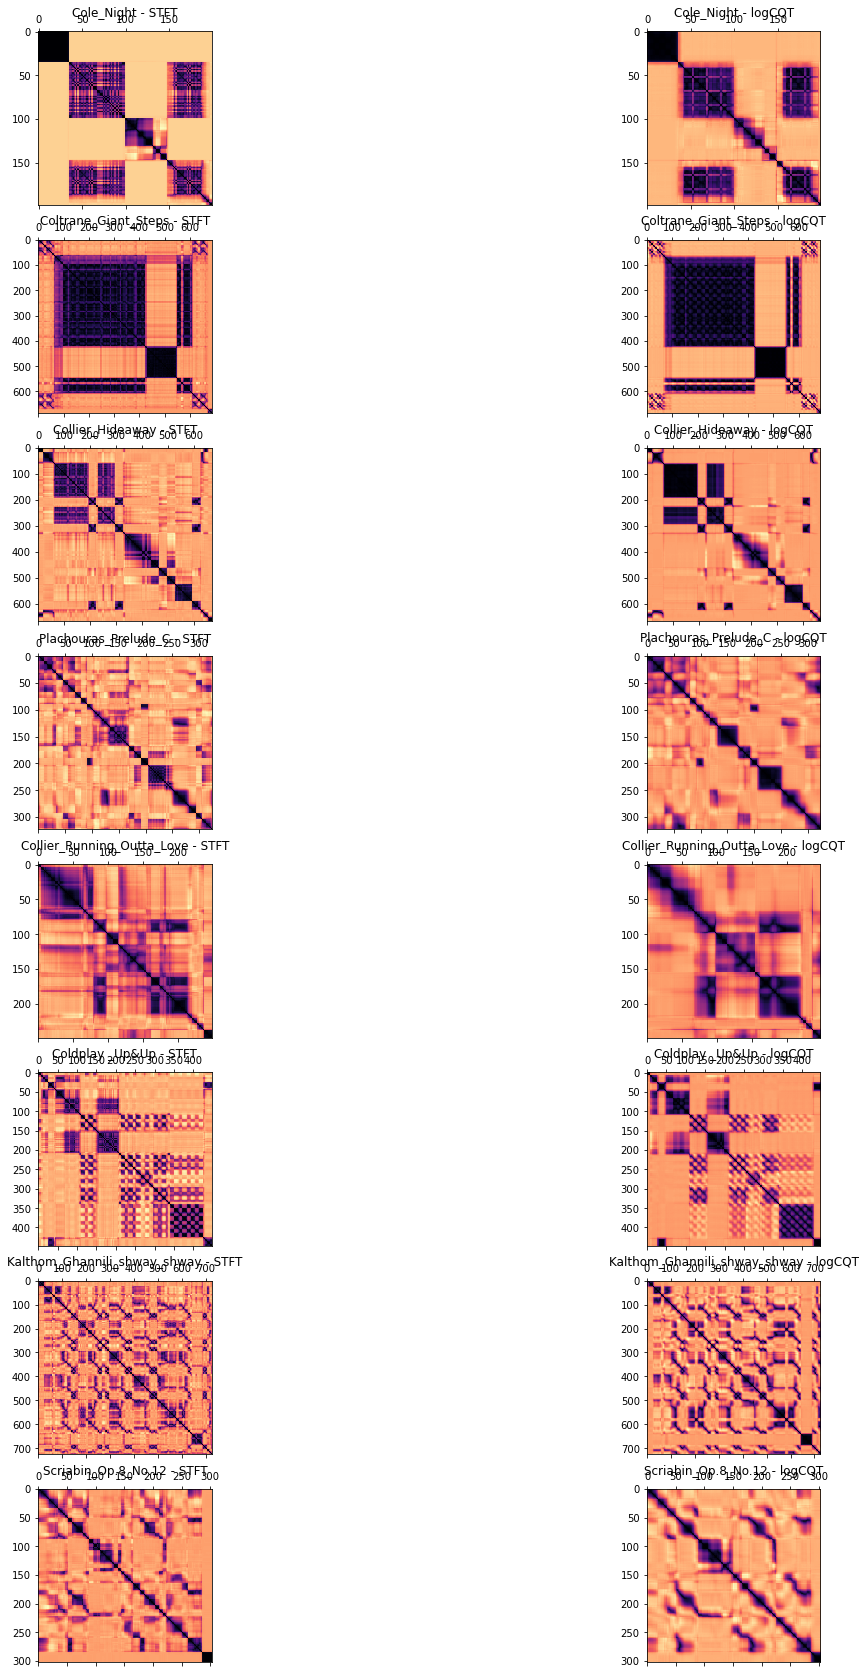

In [24]:
#Plotting original
plt.set_cmap('viridis')
fig, ax = plt.subplots(nrows=file_no, ncols=2, figsize=(20,30))
for i in range(file_no):
    ax[i,0].matshow(X["D"]["logCQT"][i], cmap='magma')
    ax[i, 0].set(title=all_names[i] + ' - STFT')
    ax[i,1].matshow(X["D"]["f_logCQT"][i], cmap='magma')
    ax[i, 1].set(title=all_names[i] + ' - logCQT')

<Figure size 432x288 with 0 Axes>

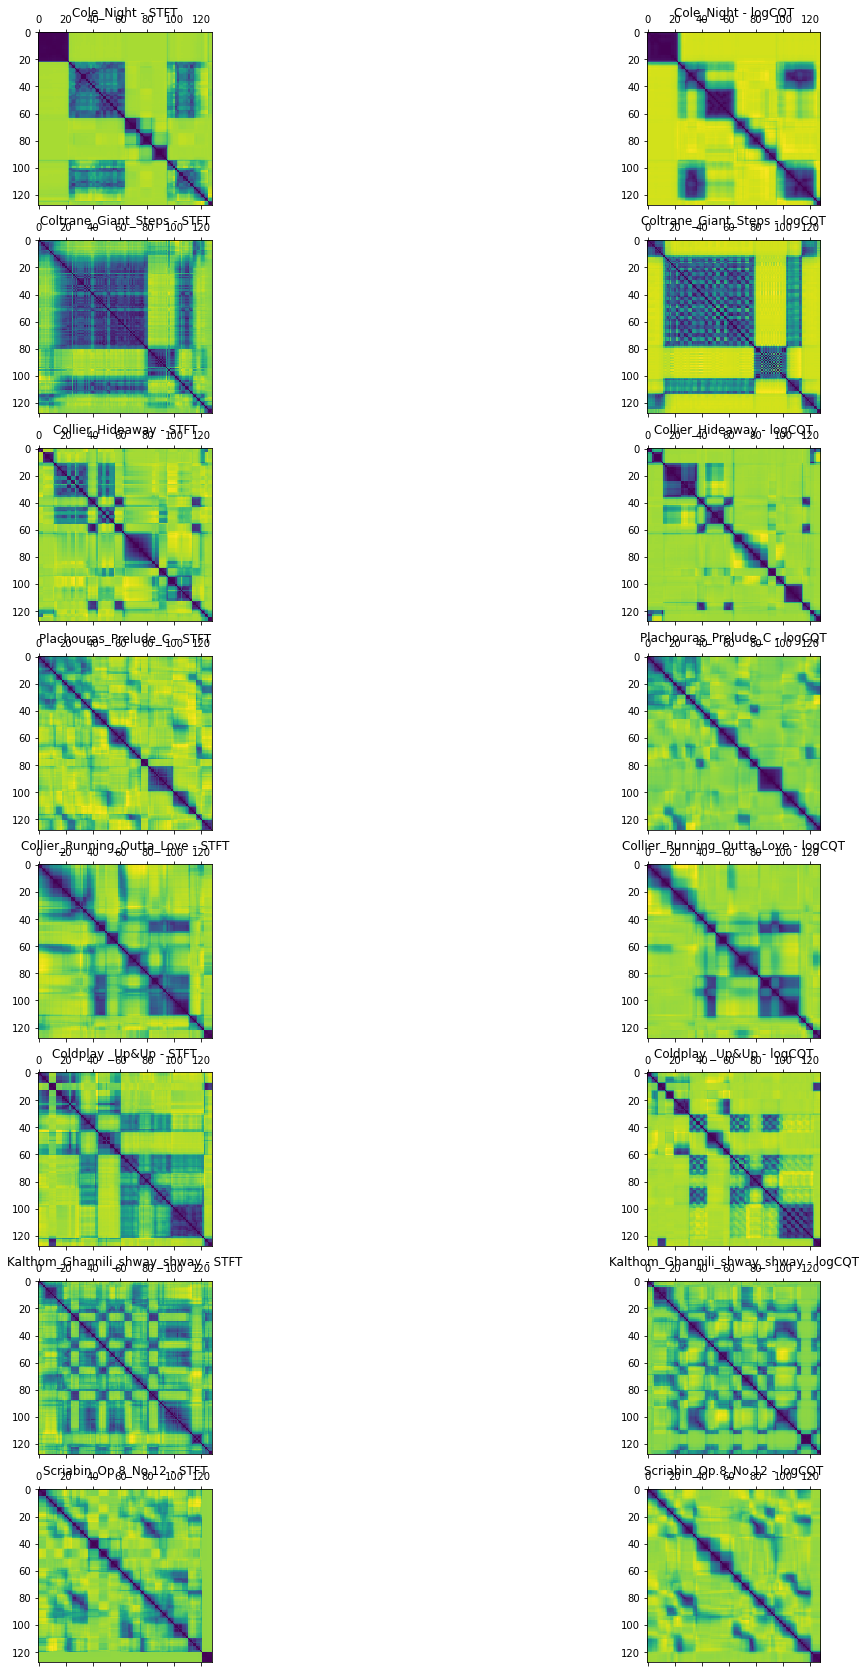

In [26]:
#Plotting from downsampled combined matrices
plt.set_cmap('viridis')
fig, ax = plt.subplots(nrows=file_no, ncols=2, figsize=(20,30))
for i in range(file_no):
    ax[i,0].matshow(X["D_d"]["logCQT"][i], cmap='viridis')
    ax[i, 0].set(title=all_names[i] + ' - STFT')
    ax[i,1].matshow(X["D_d"]["f_logCQT"][i], cmap='viridis')
    ax[i, 1].set(title=all_names[i] + ' - logCQT')